In [1]:
from pathlib import Path
import pandas as pd

## Load Data

In [2]:
x_relevance_data_path = Path(".") / "ml_data" / "x_relevance_data_v1.pd.json"
y_relevance_data_path = Path(".") / "ml_data" / "y_relevance_data_v1.pd.json"
x_relevance_data = pd.read_json(x_relevance_data_path)
y_relevance_data = pd.read_json(y_relevance_data_path)

In [3]:
#split the data for training and testing
train_size = 0.7
df_train=pd.concat([x_relevance_data,y_relevance_data],axis=1)
train_dataset=df_train.sample(frac=train_size,random_state=0).reset_index(drop=True)
valid_dataset=df_train.drop(train_dataset.index).reset_index(drop=True)

In [4]:
import os
os.chdir("..")#

In [17]:
from sources.ml_model.ml_model import MlModelWrapper
from sources.data_processing.queries import ArticleMetadata

result = []
cnt=0
epoch = 0

model = MlModelWrapper()
for ind, row in valid_dataset.iterrows():
    article = ArticleMetadata(title=row["title"], doi=row["doi"], abstract=row["abstract"],
                              journal_name=row["journal_name"], authors=["bla"], publication_date=row["publication_date"],
                              repo_identifier="testing")
    prediction, float_p = model.predict_article(article)
    result.append((row["doi"], float_p, prediction, row["relevance"]))
    
    cnt += 1
    if cnt > 10000:
        cnt = 0
        epoch += 1
        print(f"Epoch {epoch}")


Epoch 1
Epoch 2
Epoch 3
Epoch 4


In [20]:
for ind, row in enumerate(result):
    nrow = row
    nrow = (row[0], row[1], 1 if row[2] else 0, row[3])
    result[ind] = nrow

In [25]:
store = []
for ind, row in enumerate(result):
    nrow = row
    nrow = (row[0], str(row[1]), 1 if row[2] else 0, row[3])
    store.append(nrow)

In [26]:
import json
store_path = Path(".") / "ml_pipeline" / "ml_data" / "validation_data_results.json"
with store_path.open("w") as f:
    json.dump(store, f)

In [3]:
import os
os.chdir("..")

In [4]:
from pathlib import Path
import json
store_path = Path(".") / "ml_pipeline" / "ml_data" / "validation_data_results.json"
with store_path.open("r") as f:
    store = json.load(f)

In [6]:
result = []
for row in store:
    result.append((row[0], float(row[1]), row[2], row[3]))

In [15]:
y_true = [row[3] for row in result]
y_pred = [row[1]>0.4 for row in result]

In [28]:
true_pos = [row[3]==1 and row[2] == 1 for row in result] 
false_pos = [row[3]==0 and row[2] == 1 for row in result] 
true_neg = [row[3]==0 and row[2] == 0 for row in result] 
false_neg = [row[3]==1 and row[2] == 0 for row in result] 

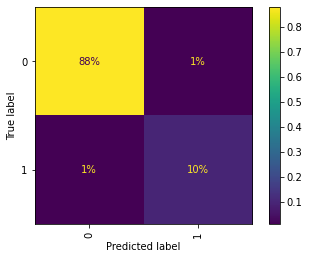

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import *

cm = confusion_matrix(y_true, y_pred, sample_weight=None,
                    labels=None, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=None)

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(include_values=True, values_format= '.0%',
                 cmap='viridis', ax=None, xticks_rotation='vertical')

plt.savefig("confusion_matrix_cutoff_0-4_normalized_all.png", dpi=600)

In [87]:
print(f"Recall Score is: {recall_score(y_true, y_pred)}")
print(f"Precision Score is: {precision_score(y_true, y_pred)}")
print(f"F1 Score is: {f1_score(y_true, y_pred)}")
print(f"Balanced Accuracy is: {balanced_accuracy_score(y_true, y_pred)}")
print(f"Cohen's Kappa Score is: {cohen_kappa_score(y_true, y_pred)}")

Recall Score is: 0.9166982203710715
Precision Score is: 0.9008372093023256
F1 Score is: 0.9086985080228956
Balanced Accuracy is: 0.9521455207165072
Cohen's Kappa Score is: 0.8973624555731513
